In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

df_train = pd.read_csv('/kaggle/input/playground-series-s5e1/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s5e1/test.csv')
df_train.dropna(inplace=True)

df_train_data = df_train.iloc[:, :-1]
df_train_label = df_train.iloc[:, -1:]

label_encoder = LabelEncoder()
x_train_encoded = df_train_data.apply(lambda col: label_encoder.fit_transform(col) if col.dtypes == 'object' else col)
y_train_encoded = df_train_label.apply(lambda col: label_encoder.fit_transform(col) if col.dtypes == 'object' else col)

x_test_encoded = df_test.apply(lambda col: label_encoder.fit_transform(col) if col.dtypes == 'object' else col)

x_train = x_train_encoded.to_numpy()
y_train = y_train_encoded.to_numpy()
y_train = y_train.ravel()

X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

X_train

/kaggle/input/playground-series-s5e1/sample_submission.csv
/kaggle/input/playground-series-s5e1/train.csv
/kaggle/input/playground-series-s5e1/test.csv


array([[109844,   1220,      2,      1,      4],
       [ 36903,    410,      0,      0,      3],
       [  8583,     95,      2,      0,      3],
       ...,
       [137537,   1528,      1,      0,      2],
       [153065,   1700,      4,      2,      0],
       [127323,   1414,      4,      0,      3]])

In [2]:
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

joblib.dump(model, 'Sales_GBM.pkl')


Mean Squared Error: 37794.12267446012
R-squared: 0.9209257344453587


['Sales_GBM.pkl']

In [4]:

param_grid = {
    'max_depth': [3, 5, 7],                   # Max depth of trees
    'learning_rate': [0.01, 0.1, 0.2],       # Learning rate (step size)
    'n_estimators': [100, 200],               # Number of boosting rounds (trees)
    'min_child_weight': [1, 5, 10],            # Minimum sum of instance weight in a child
    'gamma': [0, 0.5, 1.0],                   # Minimum loss reduction
}

xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror')

grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, Y_train)

print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'gamma': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200}


In [6]:


dtrain = xgb.DMatrix(X_train, label=Y_train)
dtest = xgb.DMatrix(X_test, label=Y_test)

params = {
    'objective': 'reg:squarederror',  # Regression task
    'max_depth': 7,                   # Prune the tree to a maximum depth of 5
    'min_child_weight': 1,           # Minimum weight in a child node
    'gamma': 1.0,                     # Minimum loss reduction for further partitioning
    'learning_rate': 0.2,             # Learning rate
    'n_estimators': 200               # Number of trees
}

num_round = 200  
model = xgb.train(params, dtrain, num_round)
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_round,
    evals=[(dtrain, 'train'), (dtest, 'eval')],
    early_stopping_rounds=10,  # Stop after 10 rounds with no improvement
    verbose_eval=True
)

# Make predictions
y_pred = model.predict(dtest)

# Evaluate performance
mse = mean_squared_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

joblib.dump(model, 'Sales_GBM.pkl')
print(f"Mean Squared Error: {mse}")
print(f'R-squared: {r2}')

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:05:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:560.66445	eval-rmse:562.16339
[1]	train-rmse:458.84552	eval-rmse:460.07876
[2]	train-rmse:379.08224	eval-rmse:380.32710
[3]	train-rmse:317.06168	eval-rmse:318.07292
[4]	train-rmse:269.34193	eval-rmse:270.29763
[5]	train-rmse:233.09657	eval-rmse:233.92662
[6]	train-rmse:206.02904	eval-rmse:206.88903
[7]	train-rmse:185.61557	eval-rmse:186.51989
[8]	train-rmse:170.47114	eval-rmse:171.41245


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:05:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[9]	train-rmse:159.71223	eval-rmse:160.76793
[10]	train-rmse:151.36628	eval-rmse:152.38713
[11]	train-rmse:145.34914	eval-rmse:146.40545
[12]	train-rmse:140.89032	eval-rmse:141.97975
[13]	train-rmse:137.59198	eval-rmse:138.65489
[14]	train-rmse:135.28800	eval-rmse:136.44838
[15]	train-rmse:133.02632	eval-rmse:134.16915
[16]	train-rmse:131.75076	eval-rmse:132.89464
[17]	train-rmse:129.83054	eval-rmse:131.02776
[18]	train-rmse:128.74010	eval-rmse:129.91528
[19]	train-rmse:127.43873	eval-rmse:128.64357
[20]	train-rmse:125.98145	eval-rmse:127.22274
[21]	train-rmse:123.55434	eval-rmse:124.87323
[22]	train-rmse:122.30856	eval-rmse:123.57999
[23]	train-rmse:121.29357	eval-rmse:122.62688
[24]	train-rmse:120.47291	eval-rmse:121.88169
[25]	train-rmse:118.79828	eval-rmse:120.26434
[26]	train-rmse:117.73203	eval-rmse:119.27198
[27]	train-rmse:117.37123	eval-rmse:118.95958
[28]	train-rmse:116.48698	eval-rmse:118.13851
[29]	train-rmse:116.20836	eval-rmse:117.91434
[30]	train-rmse:115.82322	eval-rmse

In [7]:
df_test = pd.read_csv('/kaggle/input/playground-series-s5e1/test.csv')
X_test_prediction = df_test.apply(lambda col: label_encoder.fit_transform(col) if col.dtypes == 'object' else col)
X_test_prediction.dropna(inplace=True)

print(len(X_test_prediction))

loaded_model = joblib.load('Sales_GBM.pkl')

dtest2 = xgb.DMatrix(X_test_prediction)


y_pred2 = loaded_model.predict(dtest2)
print(len(y_pred2))

df_test['predictions'] = y_pred2
df_test.to_csv('predictions_output.csv', index=False)


98550
98550


In [8]:
df = pd.read_csv('/kaggle/working/predictions_output.csv')
df_predictions = df[["id", "predictions"]]
df_predictions
df_predictions.to_csv('sales_predictions.csv', index=False)

In [9]:
df = pd.read_csv('/kaggle/working/sales_predictions.csv')
df

,id,predictions
0,230130,87.34344
1,230131,774.31020
2,230132,554.02423
3,230133,192.48502
4,230134,355.47565
...,...,...
98545,328675,337.66302
98546,328676,2431.59330
98547,328677,1928.72200
98548,328678,936.66360


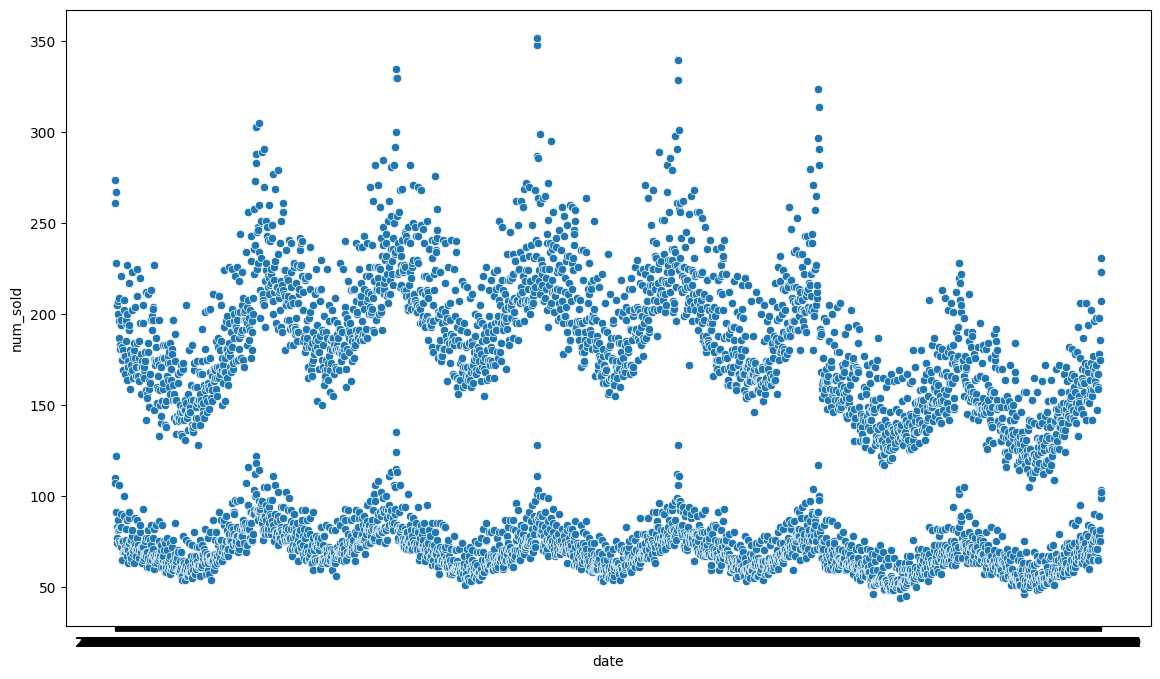

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

df_plot = pd.read_csv('/kaggle/input/playground-series-s5e1/train.csv')

df_filtered = df_plot.iloc[::30, :]

plt.figure(figsize=(14, 8))

# Create the scatter plot with the filtered data
sns.scatterplot(x="date", y="num_sold", data=df_filtered)

plt.show()

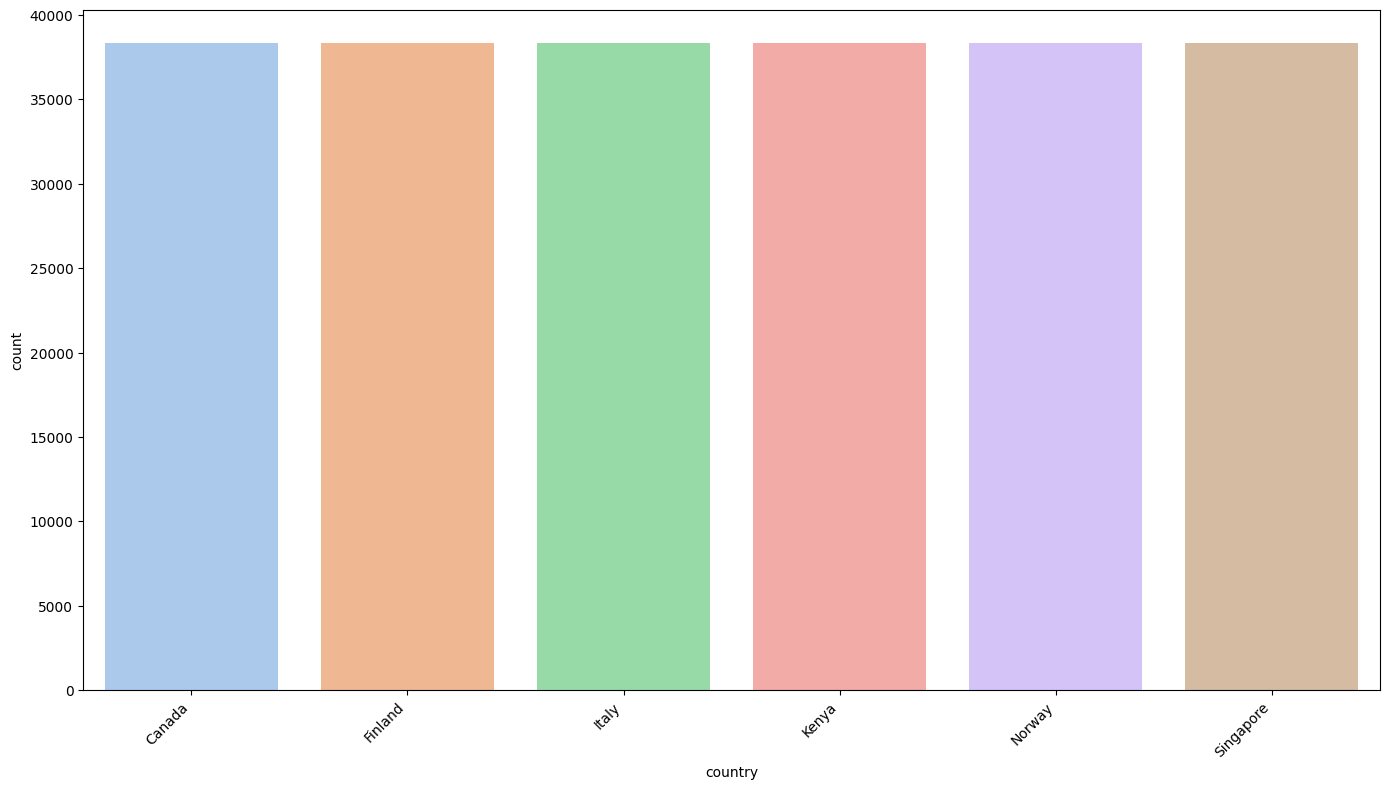

country
Canada       38355
Finland      38355
Italy        38355
Kenya        38355
Norway       38355
Singapore    38355
Name: count, dtype: int64


In [70]:
df_country = pd.read_csv('/kaggle/input/playground-series-s5e1/train.csv')


plt.figure(figsize=(14, 8))
sns.countplot(data=df_country, x='country', palette='pastel')

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

print(df_country['country'].value_counts())